In [1]:
import cv2
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split



D:\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define paths to the datasets
negative_images_dir = r"C:\Users\admin\Downloads\NWPU VHR-10 dataset\negative image set"
positive_images_dir = r"C:\Users\admin\Downloads\NWPU VHR-10 dataset\positive image set"
ground_truth_dir = r"C:\Users\admin\Downloads\NWPU VHR-10 dataset\ground truth"

In [3]:
def load_images(image_folder):
    images = []
    for filename in os.listdir(image_folder):
        img = cv2.imread(os.path.join(image_folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        images.append(img)
    return images

In [4]:
def create_binary_masks(image_size, annotations):
    masks = np.zeros(image_size, dtype=np.uint8)
    for annotation in annotations:
        cv2.rectangle(masks, (annotation[0][0], annotation[0][1]), (annotation[1][0], annotation[1][1]), 255, -1)
    return masks

In [5]:
def read_annotations(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        annotations = []
        for line in lines:
            match = re.findall(r'\d+', line)
            if match:
                annotations.append([(int(match[0]), int(match[1])), (int(match[2]), int(match[3]))])
        return annotations

In [6]:
negative_images = load_images(negative_images_dir)
positive_images = load_images(positive_images_dir)

# Extract annotations for positive images
positive_annotations = []
for filename in os.listdir(ground_truth_dir):
    if filename.endswith('.txt'):
        annotation_file_path = os.path.join(ground_truth_dir, filename)
        annotations = read_annotations(annotation_file_path)
        positive_annotations.append(annotations)


In [7]:
positive_masks = []
for annotations in positive_annotations:
    mask = create_binary_masks(positive_images[0].shape[:2], annotations)
    positive_masks.append(mask)

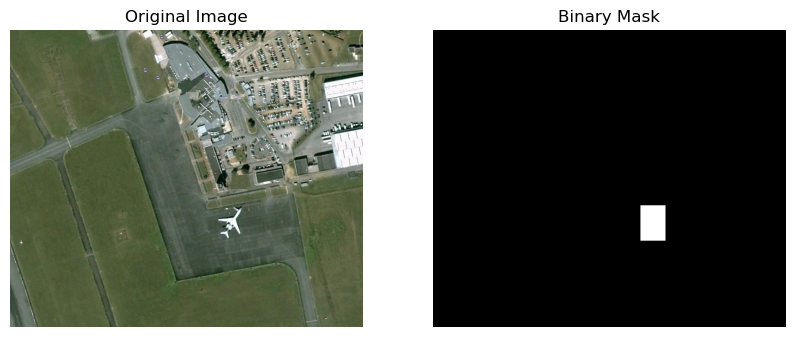

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_images[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(positive_masks[0], cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.show()

In [9]:
# Define image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [10]:
# Function to apply data augmentation
def augment_images(images):
    augmented_images = []
    for image in images:
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        augmented_image_generator = datagen.flow(image, batch_size=1)
        augmented_image = augmented_image_generator.next()[0].astype(np.uint8)
        augmented_images.append(augmented_image)
    return augmented_images


In [ ]:
augmented_positive_images = augment_images(positive_images)


In [ ]:
augmented_negative_images = negative_images.copy()


In [ ]:
# Display example of original and augmented positive image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_images[0])
plt.title('Original Positive Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_positive_images[0])
plt.title('Augmented Positive Image')
plt.axis('off')

plt.show()

In [ ]:
# Combine positive and negative images and their annotations
all_images = positive_images + negative_images
all_annotations = positive_annotations + [[] for _ in range(len(negative_images))]

# Split images and annotations into training and validation sets
train_images, val_test_images, train_annotations, val_test_annotations = train_test_split(
    all_images, all_annotations, test_size=0.2, random_state=42, stratify=[1] * len(positive_images) + [0] * len(negative_images)
)

# Further split validation and test sets
val_images, test_images, val_annotations, test_annotations = train_test_split(
    val_test_images, val_test_annotations, test_size=0.5, random_state=42, stratify=[1] * len(val_test_images) + [0] * len(val_test_images)
)

# Display the number of images in each set
print("Number of images in training set:", len(train_images))
print("Number of images in validation set:", len(val_images))
print("Number of images in test set:", len(test_images))